### Imports

In [1]:
from langgraph.graph import StateGraph, START, END
from langchain_google_genai import ChatGoogleGenerativeAI
from pydantic import BaseModel, Field
from dotenv import load_dotenv
from typing import TypedDict, Annotated
import operator

In [2]:
load_dotenv()

True

### LLM

In [3]:
model = ChatGoogleGenerativeAI(model="gemini-2.5-flash")

In [4]:
class EvaluationSchema(BaseModel):
    feedback: str = Field(..., description="Feedback on the essay")
    score: float = Field(..., description="Score for the essay (1-10)", ge=0, le=10)

In [5]:
structured_model = model.with_structured_output(EvaluationSchema)

In [6]:
essay = """The Double-Edged Sword of Technology: Progress or Problem?

In the last few decades, technology has transformed the world at an astonishing pace. From smartphones to self-driving cars, digital payments to artificial intelligence, our lives have become more efficient, connected, and convenient. However, beneath this wave of progress lies a more complex reality—technology is not just a tool for improvement; it's a force that reshapes how we live, think, and interact.

At first glance, the benefits are undeniable. Access to education has widened through online platforms. Healthcare has improved with telemedicine and predictive diagnostics. Work has become more flexible, allowing people to collaborate across continents. But with these advancements come significant concerns: digital addiction, privacy erosion, and widening inequality between those who can afford to stay ahead and those who cannot.

Consider social media—a brilliant invention to connect people. Yet today, many users report feeling more isolated, anxious, or addicted. Algorithms designed to personalize our experience often end up trapping us in echo chambers, reinforcing biases rather than expanding understanding.

Furthermore, the automation of jobs raises ethical and economic questions. While machines can handle repetitive tasks better than humans, what happens to the millions whose skills become obsolete? Are we preparing society for that shift, or just racing ahead without a plan?

The challenge, therefore, is not to slow down innovation but to guide it. We need technology that empowers, not overwhelms. That means developing policies that protect individual rights, investing in digital education for all, and designing systems that prioritize human well-being over profit.

In the end, technology is neither good nor bad—it reflects the intentions of those who wield it. The future we create will depend not just on what we build, but why and how we build it."""

In [7]:
prompt = f"Evaluate the language quality of the essay and provide feedback and assign a score out of 10.\n{essay}"
structured_model.invoke(prompt)

EvaluationSchema(feedback='The essay demonstrates excellent language quality. It is clear, concise, and well-structured, effectively using sophisticated vocabulary to articulate complex ideas. The arguments flow logically, and the sentence structures are varied and engaging. There are no significant grammatical errors, making the essay highly readable and persuasive.', score=9.0)

### State

In [8]:
class EssayState(TypedDict):
    essay: str

    clarity_of_thought: str
    depth_of_analysis: str
    language_and_style: str
    overall_feedback: str
    scores: Annotated[list[float], operator.add]
    overall_score: float

### Node Functions

In [9]:
def evaluate_calrity(state: EssayState) -> EssayState:
    clarity_of_thought = structured_model.invoke(
        f"Evaluate the clarity of thought in the essay and provide feedback and assign a score out of 10.\n{state['essay']}"
    )
    return {
        "clarity_of_thought": clarity_of_thought.feedback,
        "scores": [clarity_of_thought.score]
    }

In [10]:
def evaluate_depth(state: EssayState) -> EssayState:
    depth_of_analysis = structured_model.invoke(
        f"Evaluate the depth of analysis in the essay and provide feedback and assign a score out of 10.\n{state['essay']}"
    )
    return {
        "depth_of_analysis": depth_of_analysis.feedback,
        "scores": [depth_of_analysis.score]
    }

In [11]:
def evaluate_language(state: EssayState) -> EssayState:
    language_and_style = structured_model.invoke(
        f"Evaluate the language and style in the essay and provide feedback and assign a score out of 10.\n{state['essay']}"
    )
    return {
        "language_and_style": language_and_style.feedback,
        "scores": [language_and_style.score]
    }

In [12]:
def evaluate_overall(state: EssayState) -> EssayState:
    overall_feedback = model.invoke(
        f"Based on the essay feedbacks provide feedback summary.\nClarity of Thought feedback: {state['clarity_of_thought']}\nDepth of Analysis feedback: {state['depth_of_analysis']}\nLanguage and Style feedback: {state['language_and_style']}"
    )
    return {
        "overall_feedback": overall_feedback.content,
        "overall_score": sum(state['scores']) / len(state['scores'])
    }

### Define Graph

In [13]:
graph = StateGraph(EssayState)

### Add Nodes

In [14]:
graph.add_node("evaluate_calrity", evaluate_calrity)
graph.add_node("evaluate_depth", evaluate_depth)
graph.add_node("evaluate_language", evaluate_language)
graph.add_node("evaluate_overall", evaluate_overall)

### Add Edges

In [15]:
graph.add_edge(START, "evaluate_calrity")
graph.add_edge(START, "evaluate_depth")
graph.add_edge(START, "evaluate_language")

graph.add_edge("evaluate_calrity", "evaluate_overall")
graph.add_edge("evaluate_depth", "evaluate_overall")
graph.add_edge("evaluate_language", "evaluate_overall")

graph.add_edge("evaluate_overall", END)

### Compile Graph

In [16]:
workflow = graph.compile()

### Run

In [17]:
workflow.invoke({"essay": essay})

{'essay': "The Double-Edged Sword of Technology: Progress or Problem?\n\nIn the last few decades, technology has transformed the world at an astonishing pace. From smartphones to self-driving cars, digital payments to artificial intelligence, our lives have become more efficient, connected, and convenient. However, beneath this wave of progress lies a more complex reality—technology is not just a tool for improvement; it's a force that reshapes how we live, think, and interact.\n\nAt first glance, the benefits are undeniable. Access to education has widened through online platforms. Healthcare has improved with telemedicine and predictive diagnostics. Work has become more flexible, allowing people to collaborate across continents. But with these advancements come significant concerns: digital addiction, privacy erosion, and widening inequality between those who can afford to stay ahead and those who cannot.\n\nConsider social media—a brilliant invention to connect people. Yet today, ma

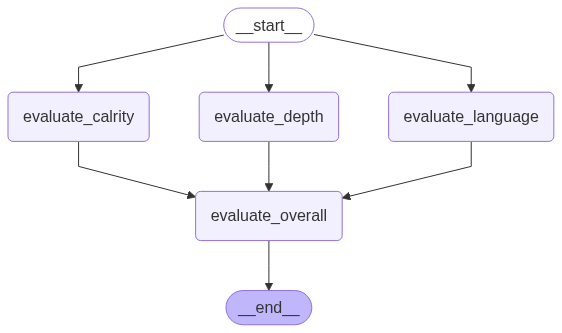

In [18]:
from IPython.display import Image
Image(workflow.get_graph().draw_mermaid_png())